In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

from plotting_functions import plot_prediction
from plotting_functions import plot_prediction_per_fold

## Function select_variables

In [2]:
def select_variables(df_data, vars, *args, drop=False):
    """
    Select or drop variables (features or labels corresponding to dataframe column names) from Pandas DataFrame based 
    on one or more lists of variable names and return DataFrame of selected variables.
    
    Parameters:
    df_data : Pd.DataFrame
        Training or testing dataset.
    vars : list
        List of variables (features or labels corresponding to dataframe column names) to select or drop.
    *args : tuple
        Additional lists of variables.
    drop : bool
        If False (default), select given variables. If True, drop given variables.
    """

    # Make list of all variables
    cols = [y for x in [vars, *args] for y in x]

    # If True, drop variables from dataframe. 
    if drop == True:
        df_data_sel = df_data.drop(cols, axis=1)
    
    #If False, select variables from dataframe.
    else: 
        df_data_sel = df_data[cols]
    
    return df_data_sel

### Test for function select_variables

In [3]:
filepath = 'Data/'

df_data_train = pd.read_csv(filepath + 'train_test/data_train_all_job_rdsplit.csv', index_col=0)

base_cols = ['BREID','altitude','aspect','slope','slope_factor','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['BREID','balance_netto']

df_data_train_X = select_variables(df_data_train, base_cols, temp_cols, prec_cols)
print(df_data_train_X.columns)
print(df_data_train_X.shape)

df_data_train_Y = select_variables(df_data_train, label_cols)
print(df_data_train_Y.columns)
print (df_data_train_Y.shape)

df_data_train_X_climate_all = select_variables(df_data_train, base_cols, temp_cols, prec_cols, drop=True)
print(df_data_train_X_climate_all.columns)
print(df_data_train_X_climate_all.shape)


Index(['BREID', 'altitude', 'aspect', 'slope', 'slope_factor',
       'altitude_climate', 't2m_oct', 't2m_nov', 't2m_des', 't2m_jan',
       't2m_feb', 't2m_mar', 't2m_apr', 't2m_may', 't2m_jun', 't2m_jul',
       't2m_aug', 't2m_sep', 'tp_oct', 'tp_nov', 'tp_des', 'tp_jan', 'tp_feb',
       'tp_mar', 'tp_apr', 'tp_may', 'tp_jun', 'tp_jul', 'tp_aug', 'tp_sep'],
      dtype='object')
(833, 30)
Index(['BREID', 'balance_netto'], dtype='object')
(833, 2)
Index(['RGIID', 'GLIMSID', 'utm_zone', 'utm_east_approx', 'utm_north_approx',
       'altitude_approx', 'location_description', 'location_id', 'stake_no',
       'utm_east',
       ...
       'tsn_des', 'tsn_jan', 'tsn_feb', 'tsn_mar', 'tsn_apr', 'tsn_may',
       'tsn_jun', 'tsn_jul', 'tsn_aug', 'tsn_sep'],
      dtype='object', length=271)
(833, 271)


## Function train_xgb_model

In [4]:
def train_xgb_model(X, y, idc_list, params):

    # Define model object.
    xgb_model = xgb.XGBRegressor()
    
    # Set up grid search. 
    clf = GridSearchCV(xgb_model, 
                       params, 
                       cv=idc_list, # Int or iterator (default for int is kfold)
                       verbose=1, # Controls number of messages
                       n_jobs=4, # No of parallell jobs
                       scoring='neg_mean_squared_error', # Can use multiple metrics
                       refit=True, # Default True. For multiple metric evaluation, refit must be str denoting scorer to be used to find the best parameters for refitting the estimator.
                       return_train_score=False) # Default False. If False, cv_results_ will not include training scores.

    # Fit model to folds
    clf.fit(X, y)

    # Get results of grid search
    print('Cross validation score: ', clf.best_score_)
    print('Grid search best hyperparameters: ', clf.best_params_)

    fitted_model = xgb.XGBRegressor(learning_rate = clf.best_params_['learning_rate'], 
                                    n_estimators = clf.best_params_['n_estimators'],
                                    max_depth = clf.best_params_['max_depth'])
    
    cvl = cross_val_score(fitted_model, X, y, cv=idc_list, scoring='neg_mean_squared_error')

    print('Cross validation scores per fold: ', cvl)
    print('Mean cross validation score: ', cvl.mean())
    print('Standard deviation: ', cvl.std())

    plot_prediction_per_fold(X, y, fitted_model, idc_list)

    return fitted_model

### Test for function train_xgb_model

In [5]:
# Test for function train_xgb_model

filepath = 'Data/'

df_data_train = pd.read_csv(filepath + 'train_test/data_train_all_job_rdsplit.csv', index_col=0)

base_cols = ['altitude','aspect','slope','slope_factor','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

df_train_X = select_variables(df_data_train, base_cols, temp_cols, prec_cols)
df_train_y = select_variables(df_data_train, label_cols)

X_train, y_train = df_train_X.values, df_train_y.values

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Cross validation score:  -0.4542650852317313
Grid search best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
Cross validation scores per fold:  [-0.49156039 -0.49804532 -0.37318954]
Mean cross validation score:  -0.4542650852317313
Standard deviation:  0.05739016500613523


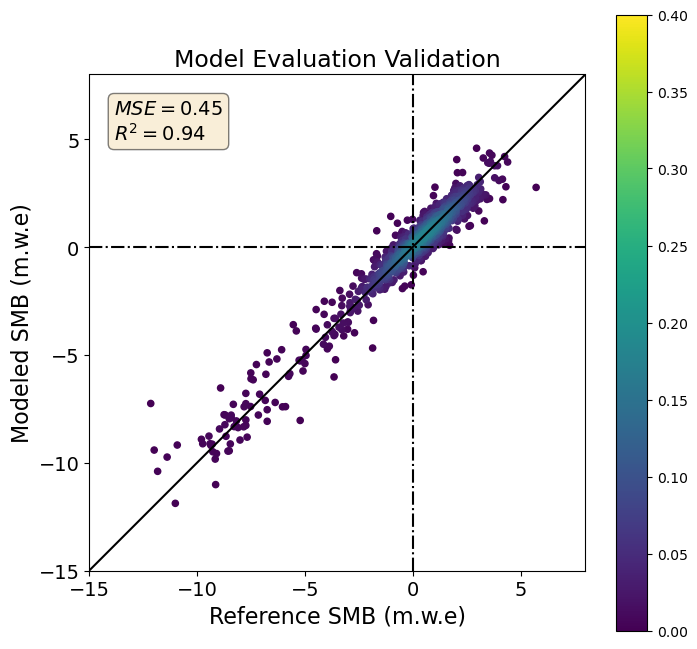

In [6]:
# Test with kfold - OK!

gs_params = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [100, 200, 300], # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.1, 0.2, 0.3]
}

# The cross validation generator returns an iterable of length n_folds, each element of which is a 2-tuple of 
# numpy 1-d arrays (train_index, test_index) containing the indices of the test and training sets for that 
# cross-validation run.
kf = KFold(n_splits = 3,
            shuffle = False,
            random_state = None) # None if shuffle=False

# Store tuples of indices from split in list. List contains fold_n = (train_index, test_index), where train_index
# and test_index are numpy arrays.
# len(indices) corresponds to number of splits.
indices_list = list(kf.split(X_train, y_train))

# Train model
best_model = train_xgb_model(X_train, y_train, indices_list, gs_params)


Fitting 4 folds for each of 36 candidates, totalling 144 fits
Cross validation score:  -1.9849340321092022
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
Cross validation scores per fold:  [-3.27625464 -2.46222599 -0.82786856 -1.37338694]
Mean cross validation score:  -1.9849340321092022
Standard deviation:  0.9497508719859848


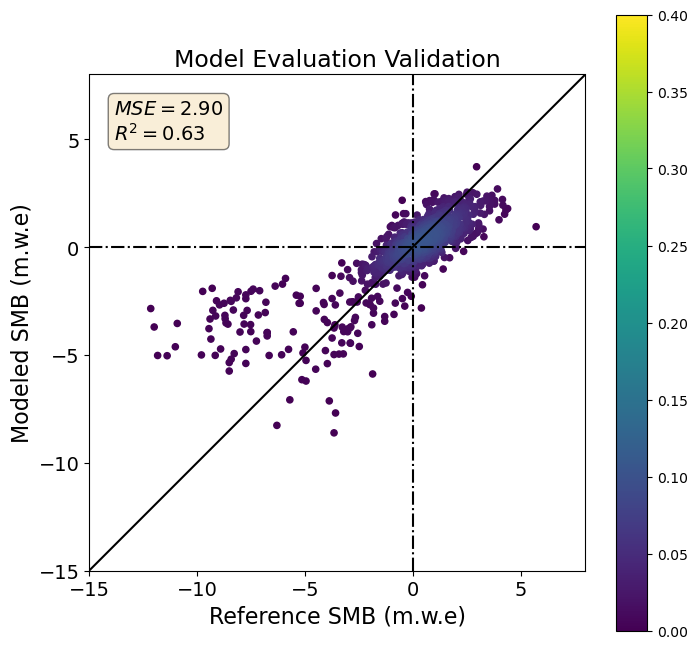

In [15]:
# Test with logo - OK!

df_train_id = select_variables(df_data_train, ['BREID'])
gp = df_train_id.values.flatten()
# Must flatten group and y-values such that they have shape (nsamples,) instead of (nsamples,1)
y_train_logo = y_train.flatten()

gs_params = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [100, 200, 300], # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.1, 0.2, 0.3]
}
              
logo = LeaveOneGroupOut()

# Generate list of tuples with indices
indices_list = list(logo.split(X_train, y_train_logo, groups=gp))

# Train model
best_model = train_xgb_model(X_train, y_train, indices_list, gs_params)
